In [6]:
import gymnasium as gym
from pogema import GridConfig
from stable_baselines3 import DQN, A2C
from stable_baselines3.common.evaluation import evaluate_policy

%load_ext autoreload
%autoreload 2
%matplotlib inline

grid_config = GridConfig(
    size=8,
    density=0.3,
    num_agents=1,
    max_episode_steps=30
)

env = gym.make("Pogema-v0",grid_config=grid_config)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/Users/aditya/miniconda3/envs/pogema/lib/python3.9/site-packages/gymnasium/utils/passive_env_checker.py:29: UserWarning: WARN: It seems a Box observation space is an image but the `dtype` is not `np.uint8`, actual type: float32. If the Box observation space is not an image, we recommend flattening the observation to have only a 1D vector.
  logger.warn(
/Users/aditya/miniconda3/envs/pogema/lib/python3.9/site-packages/gymnasium/utils/passive_env_checker.py:34: UserWarning: WARN: It seems a Box observation space is an image but the lower and upper bounds are not [0, 255]. Actual lower bound: -1.0, upper bound: 1.0. Generally, CNN policies assume observations are within that range, so you may encounter an issue if the observation values are not.
  logger.warn(


### A2C

In [15]:
a2c_model = A2C(
    "MlpPolicy",
    env,
    verbose=1,
    seed=42
)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [17]:
# Evaluate untrained agent using separate env

val_env = gym.make("Pogema-v0",grid_config=grid_config)

val_a2c_model = A2C(
    "MlpPolicy",
    val_env,
    verbose=1,
    seed=42,
)

mean_reward, std_reward = evaluate_policy(
    val_a2c_model,
    val_a2c_model.get_env(),
    deterministic=True,
    n_eval_episodes=20,
)

print(f"mean_reward: {mean_reward:.2f} +/- {std_reward:.2f}")

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
mean_reward: 0.00 +/- 0.00


In [18]:
# Train agent and save it
a2c_model.learn(total_timesteps=int(1.2e5))
a2c_model.save("saved/a2c_baseline")

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 25.7     |
|    ep_rew_mean        | 0.211    |
| time/                 |          |
|    fps                | 1795     |
|    iterations         | 100      |
|    time_elapsed       | 0        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -1.38    |
|    explained_variance | -595     |
|    learning_rate      | 0.0007   |
|    n_updates          | 99       |
|    policy_loss        | -0.0308  |
|    value_loss         | 0.00119  |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 26.3     |
|    ep_rew_mean        | 0.211    |
| time/                 |          |
|    fps                | 1871     |
|    iterations         | 200      |
|    time_elapsed       | 0        |
|    total_timesteps    | 1000     |
| train/                |          |
|

### Load trained agent and evaluate it

In [20]:
a2c_model = A2C.load("saved/a2c_baseline")

env.reset()

mean_reward, std_reward = evaluate_policy(a2c_model, env, deterministic=True, n_eval_episodes=20)
print(f"mean_reward:{mean_reward:.2f} +/- {std_reward:.2f}")

mean_reward:0.50 +/- 0.50


/Users/aditya/miniconda3/envs/pogema/lib/python3.9/site-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


### Video Recording

In [27]:
from IPython.display import SVG, display
from pogema.animation import AnimationMonitor, AnimationConfig

env = AnimationMonitor(env)

obs, info = env.reset()

# terminated = truncated = [False, ...]

# while not all(terminated) and not all(truncated):
#     # Use random policy to make actions
#     obs, reward, terminated, truncated, info = env.step([env.action_space.sample() for _ in range(grid_config.num_agents)])

#terminated = truncated = [False, ...]
terminated = truncated = False

while not terminated or not truncated:
    # Use random policy to make actions
    print(env.action_space.sample())
    obs, reward, terminated, truncated, info = env.step(env.action_space.sample())

2
0
2
2
2
1
1
2
3
1
2
3
3
4
3
1
0
0
0
3
4
4
0
4
0
4
4
2
3
2
4
1
0
3
1
1
2
2
4
1
3
1
1
0
1
0
3
0
0
2
3
4
1
0
2
3
3
4
0
4
4
2
1
2
2
1
0
4
2
0
2
0
3
0
1
1
2
1
4
2
4
0
3
3
0
2
2
0
4
0
3
0
2
1
0
2
0
4
4
4
1
2
1
4
4
3
2
3
1
4
3
0
2
3
2
4
1
4
3
3
1
4
1
1
1
1
4
0
2
1
2
4
4
3
3
2
2
4
0
0
4
3
4
0
4
4
3
4
4
0
1
0
1
1
2
2
4
4
4
4
0
3
2
0
1
1
0


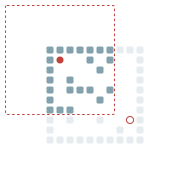

In [28]:
env.save_animation("render.svg", AnimationConfig(egocentric_idx=0))
display(SVG('render.svg'))